# Suppress Printing

In [66]:
import sys, os
old = sys.stdout
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = old

# Load Back Projected ICA Data

In [67]:
import scipy.io as sio

In [68]:
enablePrint()
filepath = '/Users/apple/Desktop/eeglab14_1_2b/ICA_Data/EEGData1.mat'
mat_contents = sio.loadmat(filepath)
ica = mat_contents['data']
temp_trial = ica[:,:,1]
trial = ica.shape[2]
print("{}: {}".format("Total number of trials is", trial))
channel = temp_trial.shape[0]
print("{}: {}".format("Total number of channels in each trial is", channel))
timepoint = temp_trial.shape[1]
print("{}: {}".format("Total number of time points in per channel per trial is", timepoint))

Total number of trials is: 40
Total number of channels in each trial is: 32
Total number of time points in per channel per trial is: 8064


# Testing between 1 trial 2 channels with GC

In [69]:
import statsmodels.tsa.stattools as stm
import numpy as np

In [70]:
#we just gonna pick temp_trial
print(temp_trial.shape)
hz = 128
#a 3 second pre-trial baseline removed
temp_trial = temp_trial[:,128*3:]
print(temp_trial.shape)

(32, 8064)
(32, 7680)


In [71]:
a = np.asarray(temp_trial[0,:])
b = np.asarray(temp_trial[1,:])
x = np.vstack((a, b)).T
print(x.shape)

(7680, 2)


In [72]:
from statsmodels.tsa.ar_model import AR
model = AR(a)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
maxlag = model_fit.k_ar

Lag: 36


In [73]:
addconst = True
verbose = True

In [74]:
result = stm.grangercausalitytests(x, maxlag, addconst, verbose)
optimal_lag = -1
F_test = -1.0
for key in result.keys():
    _F_test_ = result[key][0]['params_ftest'][0]
    if _F_test_ > F_test:
        F_test = _F_test_
        optimal_lag = key


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=140.9611, p=0.0000  , df_denom=7676, df_num=1
ssr based chi2 test:   chi2=141.0162, p=0.0000  , df=1
likelihood ratio test: chi2=139.7370, p=0.0000  , df=1
parameter F test:         F=140.9611, p=0.0000  , df_denom=7676, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=306.1023, p=0.0000  , df_denom=7673, df_num=2
ssr based chi2 test:   chi2=612.6036, p=0.0000  , df=2
likelihood ratio test: chi2=589.3915, p=0.0000  , df=2
parameter F test:         F=306.1023, p=0.0000  , df_denom=7673, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=277.6453, p=0.0000  , df_denom=7670, df_num=3
ssr based chi2 test:   chi2=833.6961, p=0.0000  , df=3
likelihood ratio test: chi2=791.4595, p=0.0000  , df=3
parameter F test:         F=277.6453, p=0.0000  , df_denom=7670, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=204.5570, p=0.

ssr based F test:         F=24.9183 , p=0.0000  , df_denom=7589, df_num=30
ssr based chi2 test:   chi2=753.5582, p=0.0000  , df=30
likelihood ratio test: chi2=718.7142, p=0.0000  , df=30
parameter F test:         F=24.9183 , p=0.0000  , df_denom=7589, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=23.8377 , p=0.0000  , df_denom=7586, df_num=31
ssr based chi2 test:   chi2=745.1047, p=0.0000  , df=31
likelihood ratio test: chi2=711.0106, p=0.0000  , df=31
parameter F test:         F=23.8378 , p=0.0000  , df_denom=7586, df_num=31

Granger Causality
number of lags (no zero) 32
ssr based F test:         F=24.6581 , p=0.0000  , df_denom=7583, df_num=32
ssr based chi2 test:   chi2=795.8237, p=0.0000  , df=32
likelihood ratio test: chi2=757.0837, p=0.0000  , df=32
parameter F test:         F=24.6581 , p=0.0000  , df_denom=7583, df_num=32

Granger Causality
number of lags (no zero) 33
ssr based F test:         F=24.9976 , p=0.0000  , df_denom=7580, df_num=3

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 33
  'rank is %d' % (J, J_), ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 32
  'rank is %d' % (J, J_), ValueWarning)


In [75]:
print("{} {}".format("We are going to look into the GC with Optimal Lag of", optimal_lag))

We are going to look into the GC with Optimal Lag of 2


We consider the p-value of the test as a measure for Granger causality: rejection of ℋ0 (p < 0.03) signifies Granger causality, acceptance means non-causality.

The causality relations drawn from systems with very small values of |det(ΛˆI)| are not meaningful

In [76]:
if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
    print(result[optimal_lag][0]['params_ftest'][0])

306.1023099421199


# Compute one Multivariant Granger Causality Matrix MGCM

In [91]:
from matplotlib import pyplot
import math
import time

In [92]:
#temp_trial = temp_trial[:,1::8] #TODO
time_start = time.clock()
MGCM = np.zeros((channel,channel))
for i in range(channel):
    for j in range(channel):
        if i == j:
            blockPrint()
            print("{}:{}".format(i,j))
            MGCM[i,j] = 0
        blockPrint()
        x = np.vstack((np.asarray(temp_trial[i,:]), np.asarray(temp_trial[j,:]))).T
        #model = AR(a)
        #model_fit = model.fit()
        #maxlag = model_fit.k_ar
        #if maxlag > 5:
        maxlag = 3
        result = stm.grangercausalitytests(x, maxlag, addconst = True, verbose = True)
        optimal_lag = 2
        F_test = -1.0
        for key in result.keys():
            _F_test_ = result[key][0]['params_ftest'][0]
            if _F_test_ > F_test:
                F_test = _F_test_
                optimal_lag = key
        enablePrint()
        #print(optimal_lag)
        blockPrint()
        if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
            MGCM[i,j] = math.log(result[optimal_lag][0]['params_ftest'][0])
        else:
            MGCM[i,j] = 0
blockPrint()
diag = np.max(MGCM)
for i in range(channel):
    for j in range(channel):
        if i == j:
            MGCM[i,j] = 1
        else:
            MGCM[i,j] = MGCM[i,j]/diag

Time Used: 8.034980000000132


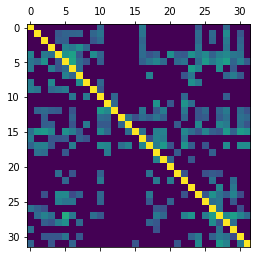

In [93]:
enablePrint()
pyplot.matshow(MGCM)
pyplot.show()
time_elapsed = (time.clock() - time_start)
print("{}: {}".format("Time Used", time_elapsed))

In [94]:
print(np.mean(MGCM))
print(np.median(MGCM))
print(np.max(MGCM))
print(np.min(MGCM))

0.14601210799756287
0.0
1.0
0.0


In [95]:
print("{}:{}".format("Hours needed", time_elapsed*40*32/60/60))

Hours needed:2.856881777777825


In [80]:
#GoogleColab takes 34 seconds
#Hours needed:33.8410016
#Hours needed:2.871406577777816 no optimal maxlag =5
#Hours needed:4.871406577777816 no optimal maxlag =5

# Split data computing MGCM for LSTM

In [34]:
temp_trial = ica[:,:,1]
trial = ica.shape[2]
print("{}: {}".format("Total number of trials is", trial))
channel = temp_trial.shape[0]
print("{}: {}".format("Total number of channels in each trial is", channel))
timepoint = temp_trial.shape[1]
print("{}: {}".format("Total number of time points in per channel per trial is", timepoint))

Total number of trials is: 40
Total number of channels in each trial is: 32
Total number of time points in per channel per trial is: 8064


In [35]:
from matplotlib import pyplot
import math
import time

In [36]:
hz = 128
#a 3 second pre-trial baseline removed
lstm_trial = temp_trial[:,128*3:]
print(temp_trial.shape)
print(lstm_trial.shape)

(32, 8064)
(32, 7680)


In [37]:
current_trial = lstm_trial[:,0*hz:(0+1)*hz]
print(current_trial.shape)

(32, 128)


In [38]:
from statsmodels.tsa.ar_model import AR
a = np.asarray(current_trial[0,:])
b = np.asarray(current_trial[17,:])
x = np.vstack((a, b)).T
print(x.shape)

model = AR(a)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
maxlag = model_fit.k_ar
if maxlag > 3:
    maxlag =3

(128, 2)
Lag: 13


In [39]:
blockPrint()
result = stm.grangercausalitytests(x, maxlag, addconst, verbose)
optimal_lag = -1
F_test = -1.0
for key in result.keys():
    _F_test_ = result[key][0]['params_ftest'][0]
    if _F_test_ > F_test:
        F_test = _F_test_
        optimal_lag = key
enablePrint()
print("{} {}".format("We are going to look into the GC with Optimal Lag of", optimal_lag))

We are going to look into the GC with Optimal Lag of 7


Here split the dataset second by second and compute the MGCM for each 128 datapoints. Since 7680/128 = 60 seconds, the sanity check is good

In [40]:
temp_list = []
#load for lstm

0


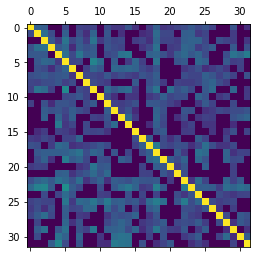

1


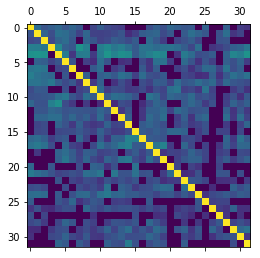

2


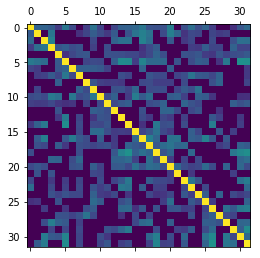

3


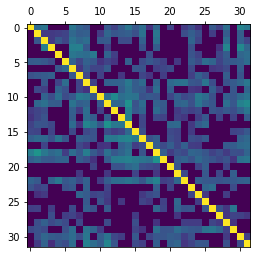

4


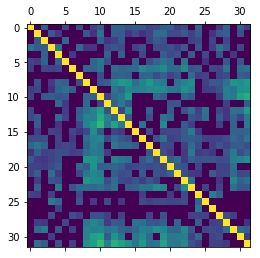

5


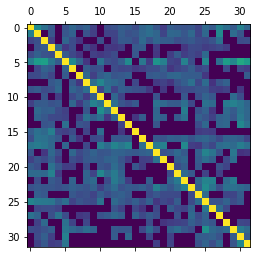

6


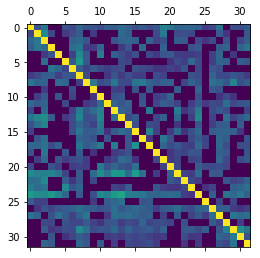

7


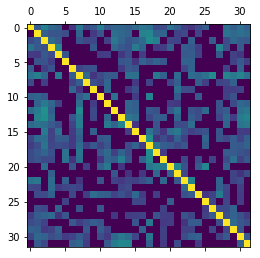

8


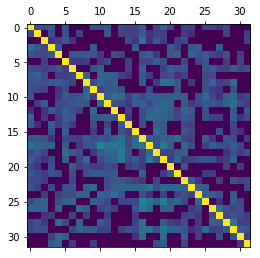

9


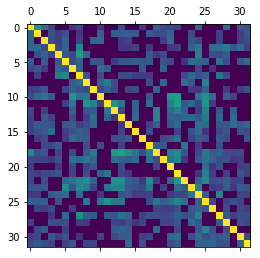

10


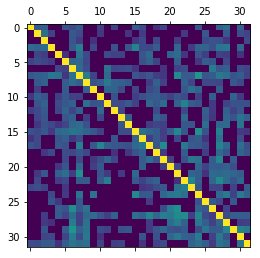

11


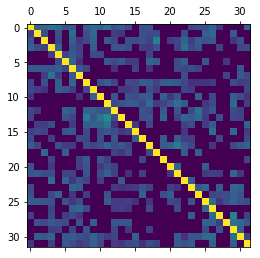

12


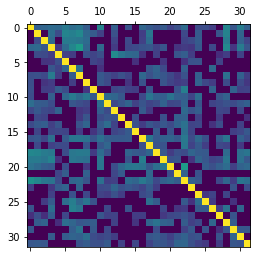

13


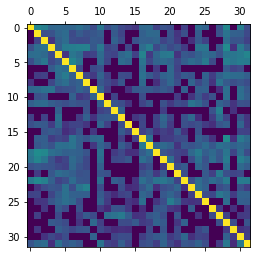

14


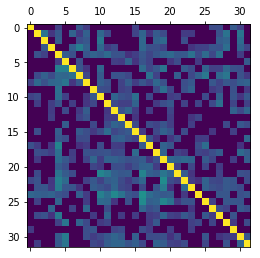

15


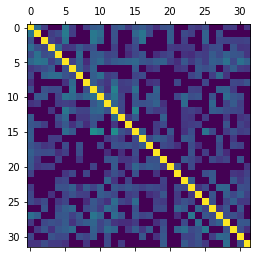

16


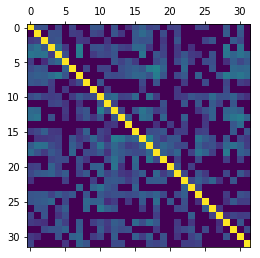

17


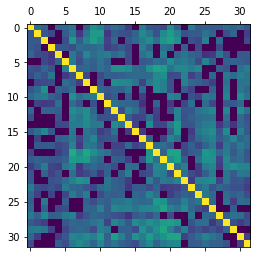

18


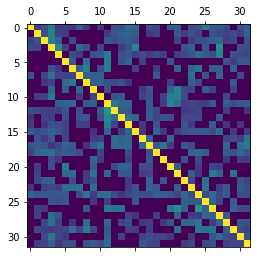

19


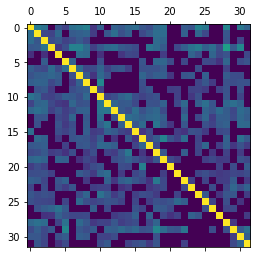

20


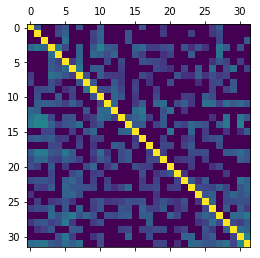

21


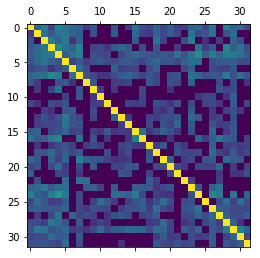

22


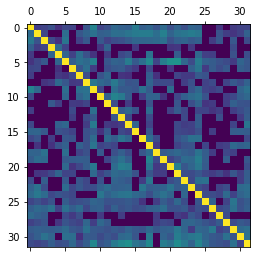

23


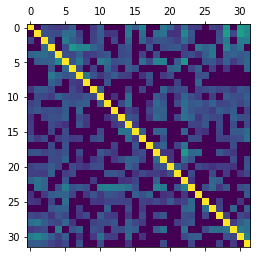

24


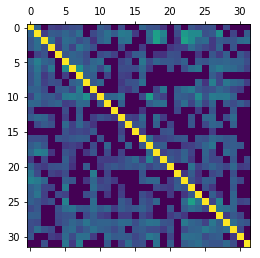

25


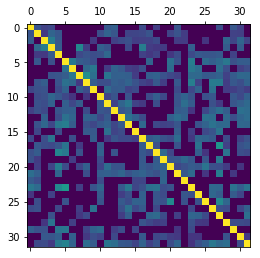

26


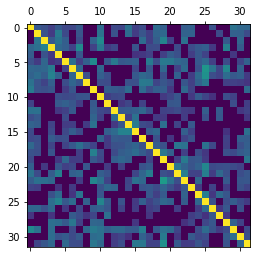

27


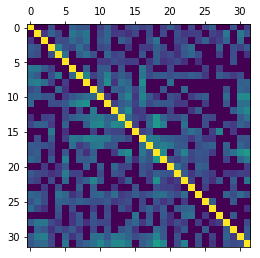

28


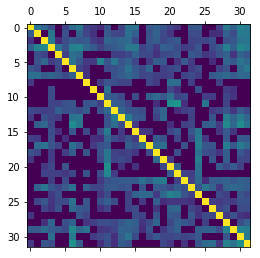

29


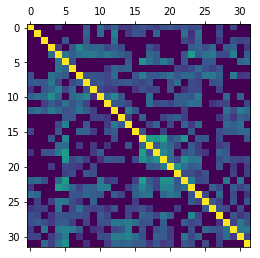

30


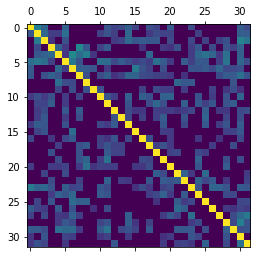

31


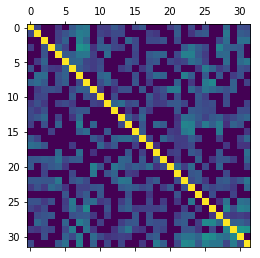

32


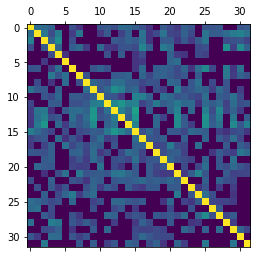

33


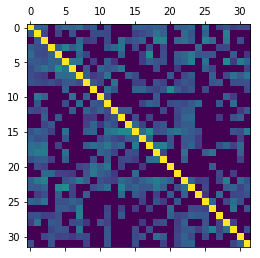

34


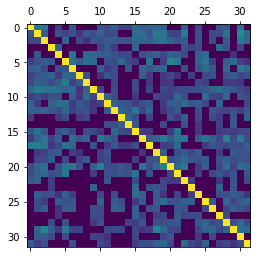

35


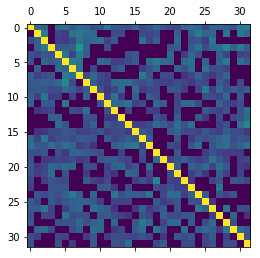

36


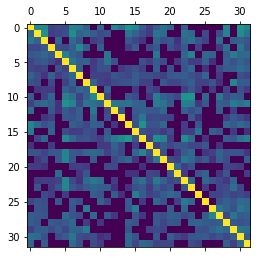

37


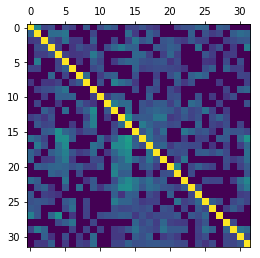

38


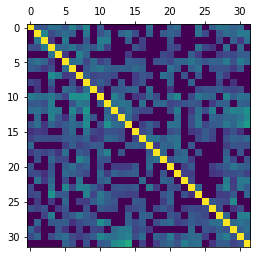

39


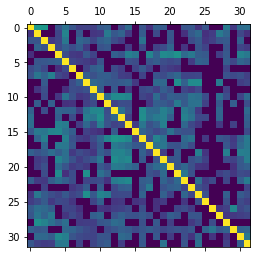

40


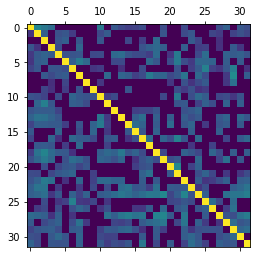

41


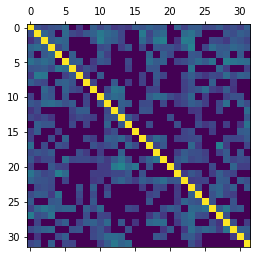

42


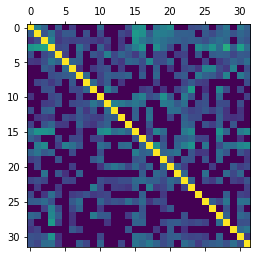

43


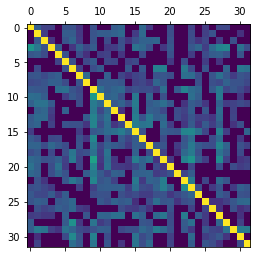

44


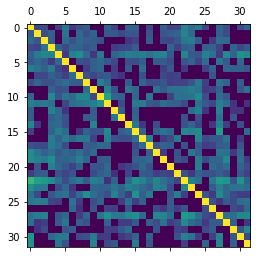

45


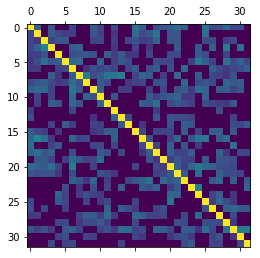

46


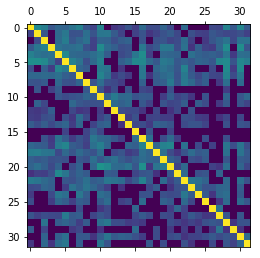

47


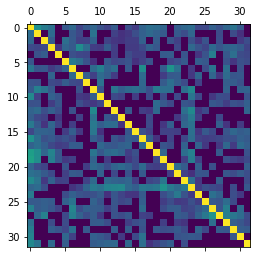

48


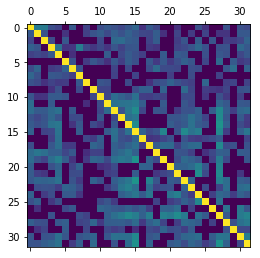

49


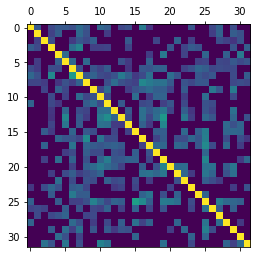

50


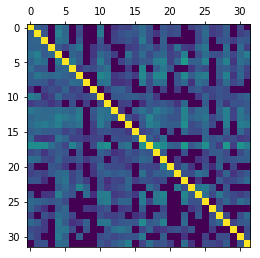

51


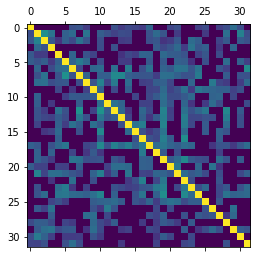

52


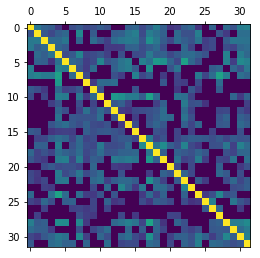

53


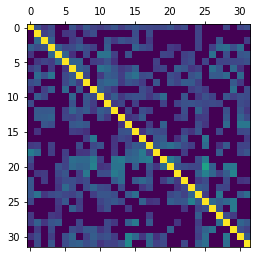

54


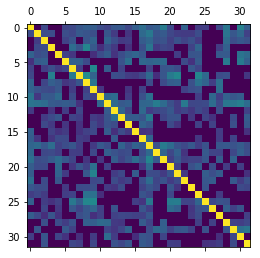

55


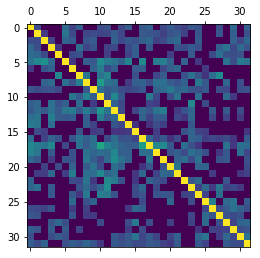

56


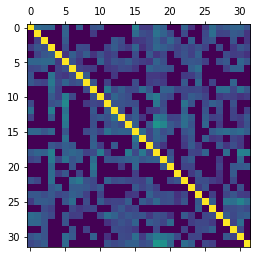

57


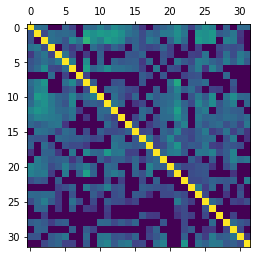

58


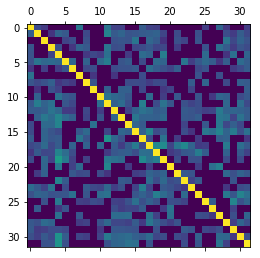

59


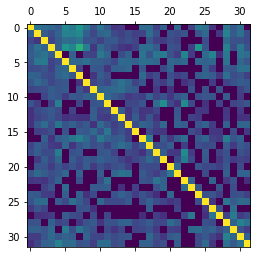

Time Used: 1106.3977209999998


In [41]:
time_start = time.clock()
for k in range(60):
    print(k)
    blockPrint()
    current_trial = lstm_trial[:, k*hz:(k+1)*hz]
    for i in range(channel):
        for j in range(channel):
            if i == j:
                print("{} -> {}:{}".format(k,i,j))
                MGCM[i,j] = 0
            blockPrint()
            a = np.asarray(current_trial[i,:])
            b = np.asarray(current_trial[j,:])
            x = np.vstack((a, b)).T
            model = AR(a)
            model_fit = model.fit()
            maxlag = model_fit.k_ar
            if maxlag > 8:
                maxlag = 8
            result = stm.grangercausalitytests(x, maxlag, addconst = True, verbose = True)
            optimal_lag = -1
            F_test = -1.0
            for key in result.keys():
                _F_test_ = result[key][0]['params_ftest'][0]
                if _F_test_ > F_test:
                    F_test = _F_test_
                    optimal_lag = key
            if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
                MGCM[i,j] = math.log(result[optimal_lag][0]['params_ftest'][0])
            else:
                MGCM[i,j] = 0
    enablePrint()
    diag = np.max(MGCM)
    #print(diag)
    for i in range(channel):
        for j in range(channel):
            if i == j:
                MGCM[i,j] = 1
            else:
                MGCM[i,j] = MGCM[i,j]/diag
    enablePrint()
    temp_list.append(MGCM)
    pyplot.matshow(MGCM)
    pyplot.show()
time_elapsed = (time.clock() - time_start)
print("{}: {}".format("Time Used", time_elapsed))

In [42]:
print("{} {}".format("Hours needed", time_elapsed*40*32/60/60))

Hours needed 393.3858563555554


In [43]:
print(len(temp_list)) #should be 60

60
